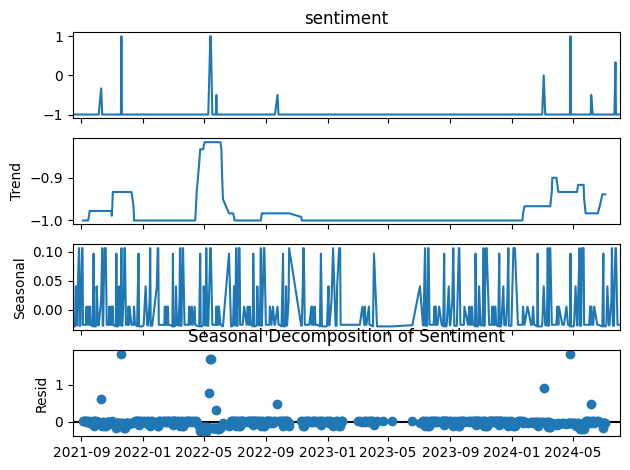

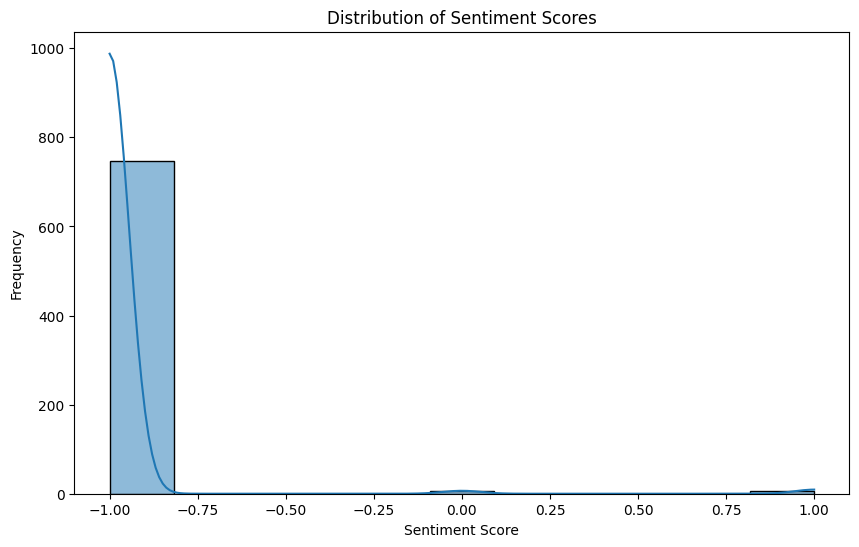

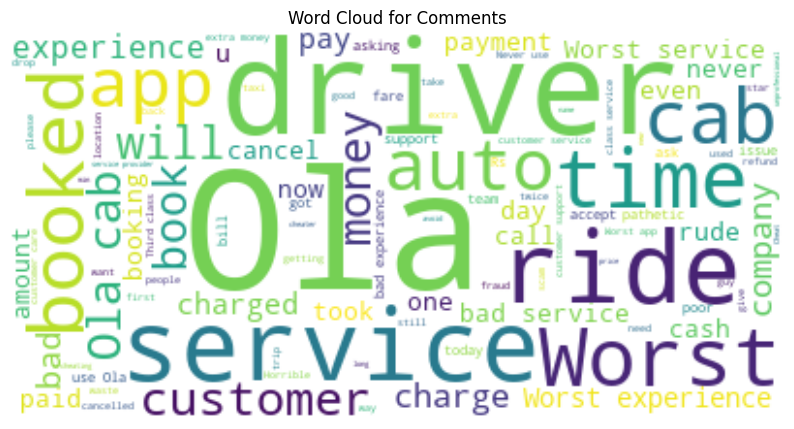

Linear Regression - Mean Squared Error: 0.0010
Decision Tree - Mean Squared Error: 0.0035
Support Vector Machine - Mean Squared Error: 0.0098
Random Forest - Mean Squared Error: 0.0041
XGBoost - Mean Squared Error: 0.0035


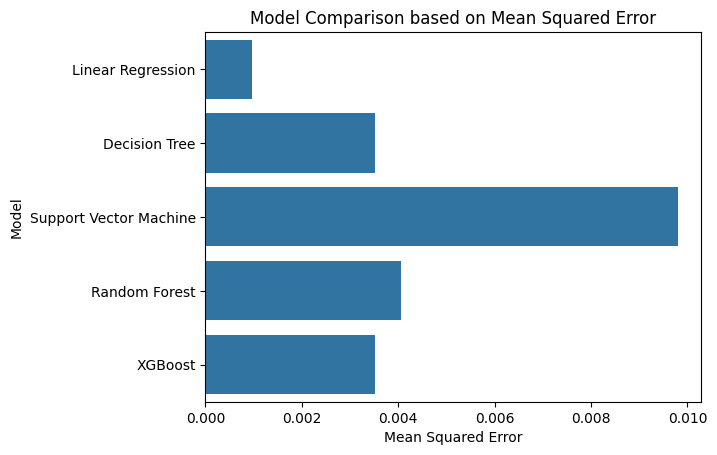

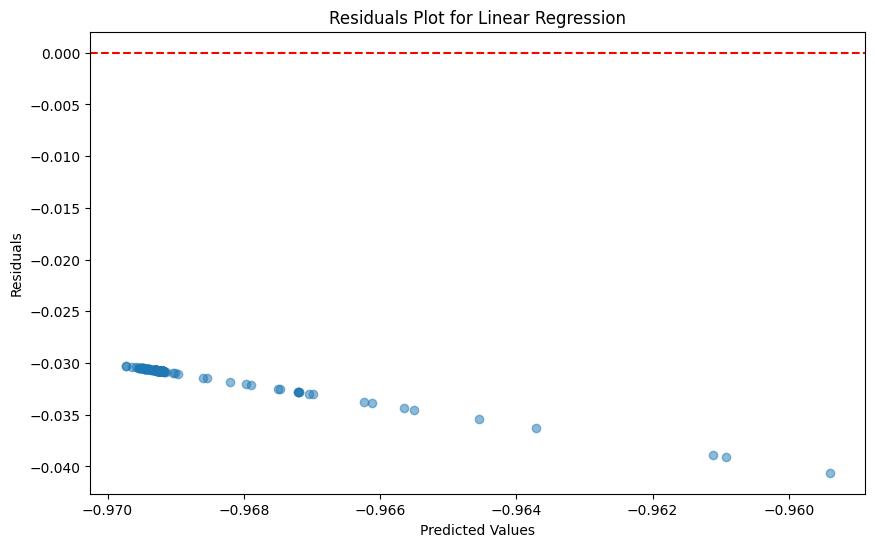

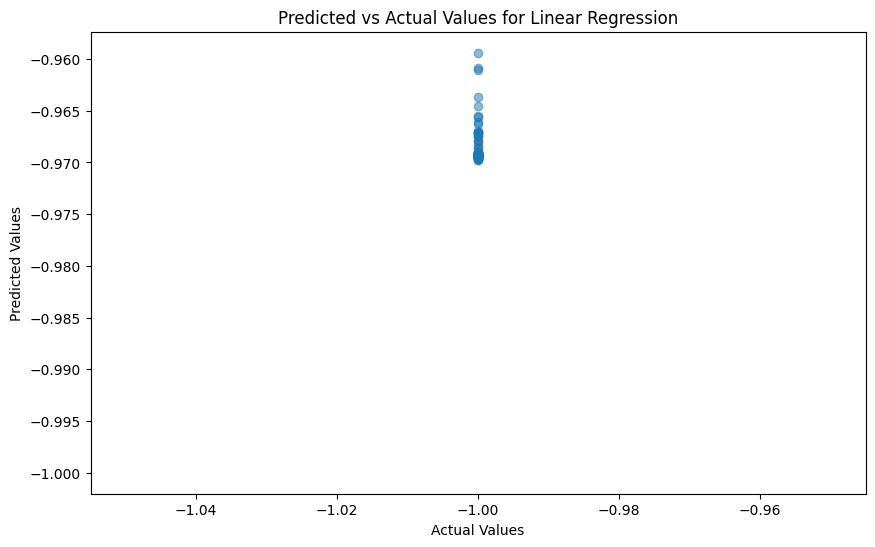

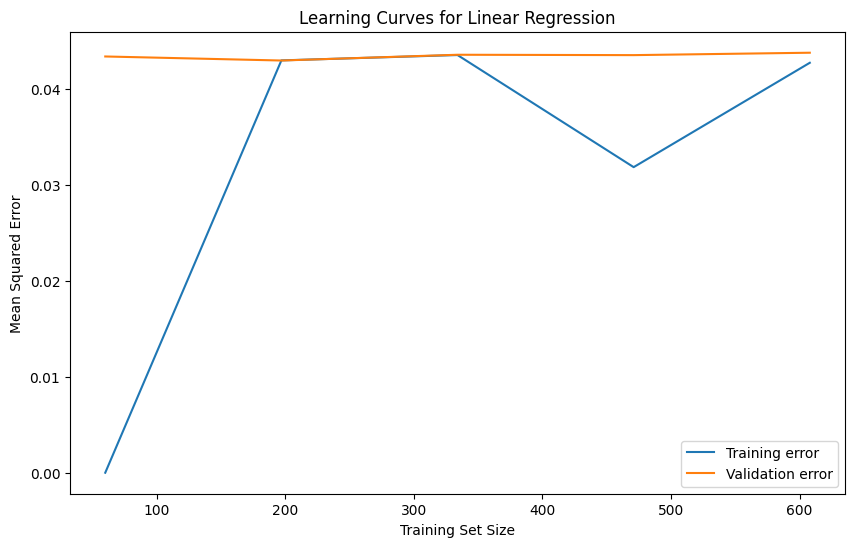

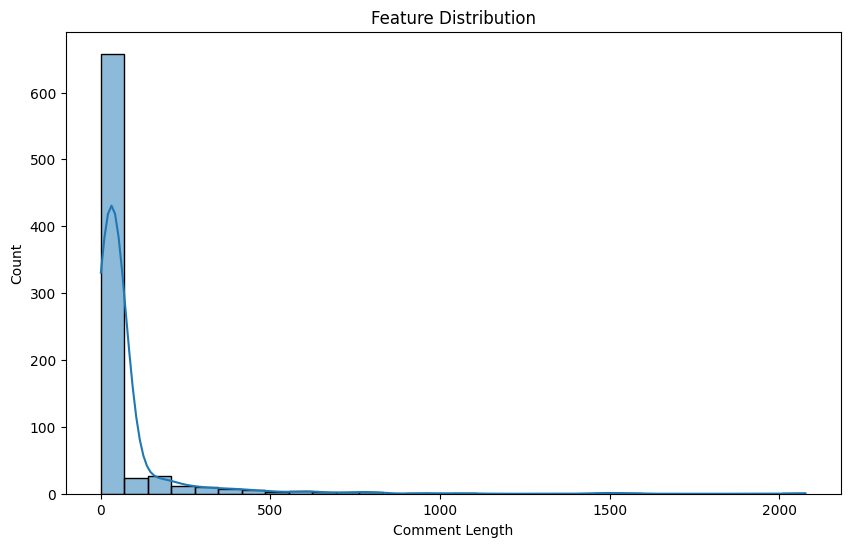

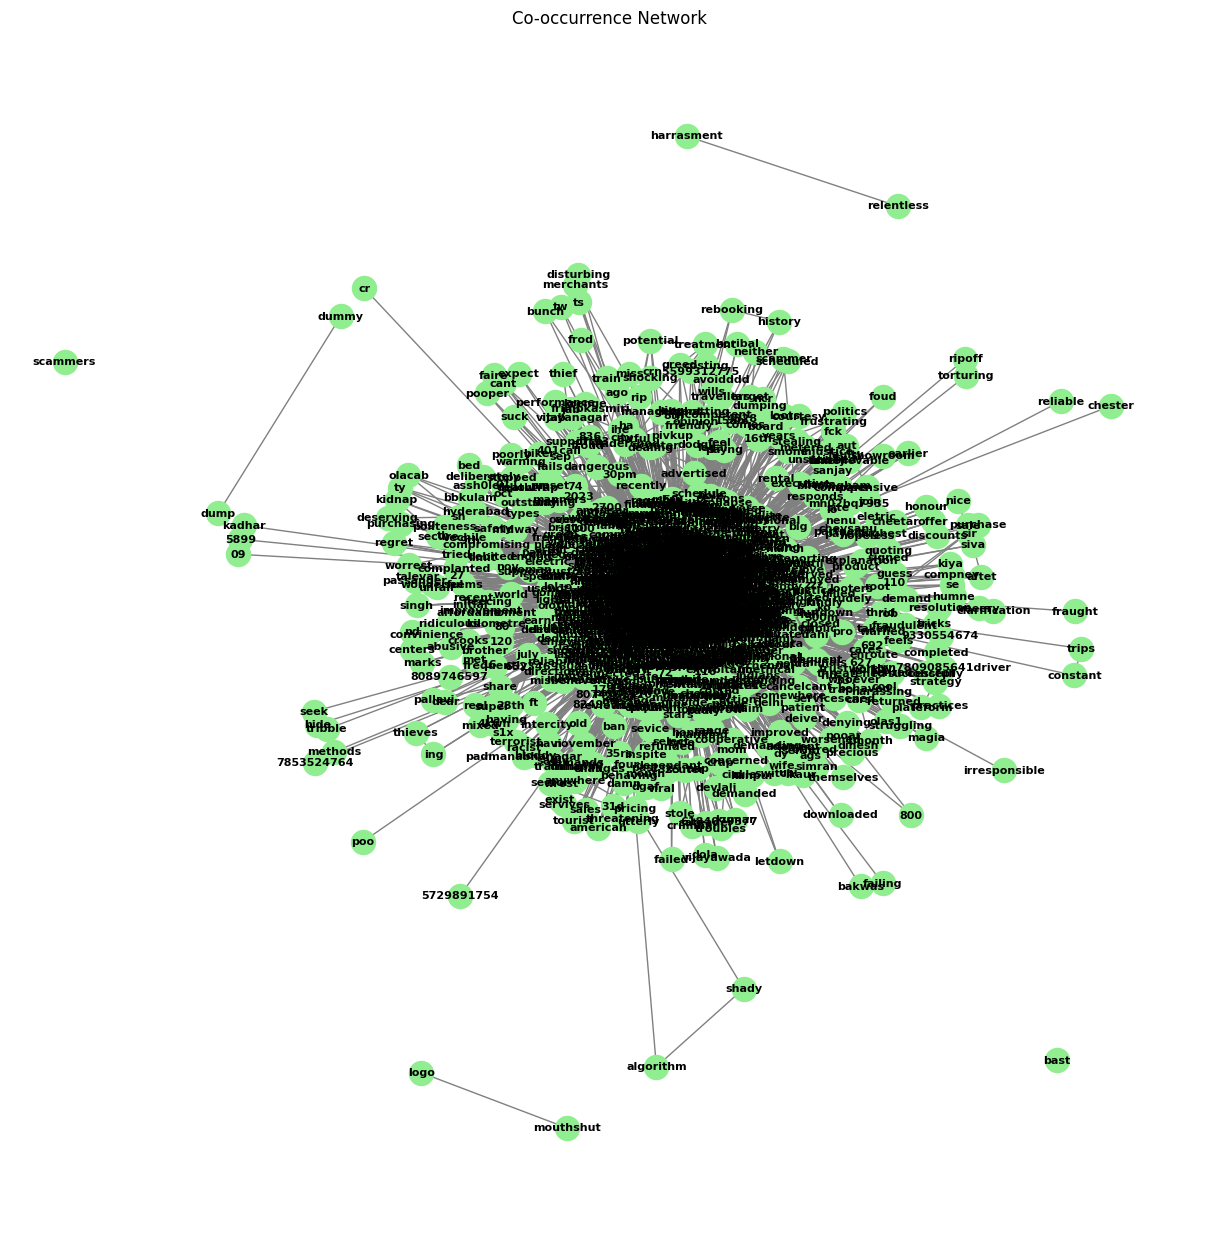

In [1]:
#Part 4(Comprehensive Sentiment Analysis and Predictive Modeling) for Ola dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import networkx as nx
from sklearn.model_selection import learning_curve, cross_val_score

# Load your Excel file
df = pd.read_excel(r"C:\Users\prabi\OneDrive\Desktop\V sem\FDS_project\Datasets\Ola.xlsx")

# Basic Preprocessing

# --- Comment Length Calculation with Error Handling ---
df['comment_length'] = df['Comment'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# --- Sentiment Mapping ---
df['sentiment'] = df['Outcome'].str.lower().map({'positive': 1, 'neutral': 0, 'negative': -1})

# Check if sentiment is valid
if df['sentiment'].isna().sum() == 0:

    # --- Time Series Analysis (If Date exists) ---
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])  # Drop rows where 'Date' conversion failed
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)  # Ensure data is sorted by date
        # Resample if necessary (e.g., daily)
        df_resampled = df['sentiment'].resample('D').mean()
        result = seasonal_decompose(df_resampled.dropna(), model='additive', period=30)
        result.plot()
        plt.title('Seasonal Decomposition of Sentiment')
        plt.show()

    # --- Sentiment Distribution Analysis ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sentiment'], kde=True)
    plt.title("Distribution of Sentiment Scores")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()

    # --- Word Cloud for Comment Analysis ---
    text = " ".join(comment for comment in df['Comment'] if isinstance(comment, str))
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Comments")
    plt.show()

    # --- Predictive Analytics ---
    X = df[['comment_length']]  # You can add other features here
    y = df['sentiment']

    # Ensure there are no NaN values in X and y
    valid_indices = X['comment_length'].notna() & y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    # Split the data into training and test sets
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'Support Vector Machine': SVR(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        # Train, predict, and evaluate each model
        results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name] = mse
            print(f'{name} - Mean Squared Error: {mse:.4f}')

        # --- Compare the results ---
        results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
        sns.barplot(x='Mean Squared Error', y='Model', data=results_df)
        plt.title("Model Comparison based on Mean Squared Error")
        plt.show()

        # --- Residual Plot for Best Performing Model ---
        best_model_name = min(results, key=results.get)
        best_model = models[best_model_name]
        y_pred = best_model.predict(X_test)
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {best_model_name}')
        plt.show()

        # --- Predicted vs Actual Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs Actual Values for {best_model_name}')
        plt.show()

        # --- Learning Curves ---
        train_sizes, train_scores, test_scores = learning_curve(
            best_model, X, y, cv=5, scoring='neg_mean_squared_error')
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training error')
        plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation error')
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Squared Error')
        plt.title(f'Learning Curves for {best_model_name}')
        plt.legend()
        plt.show()

        # --- Feature Distribution Plot ---
        plt.figure(figsize=(10, 6))
        sns.histplot(df['comment_length'], bins=30, kde=True)
        plt.xlabel('Comment Length')
        plt.title('Feature Distribution')
        plt.show()

        # --- Model Performance Comparison Box Plot ---
        cv_results = {}
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            cv_results[name] = -scores
        cv_results_df = pd.DataFrame(cv_results)
        cv_results_df.plot.box(figsize=(10, 6))
        plt.title('Model Performance Comparison (Cross-Validation)')
        plt.ylabel('Mean Squared Error')
        plt.show()

        # --- Error Distribution Plot ---
        errors = y_test - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title(f'Error Distribution for {best_model_name}')
        plt.show()

        # --- Co-occurrence Network ---
        comments = [comment for comment in df['Comment'] if isinstance(comment, str)]
        vectorizer = CountVectorizer()
        X_counts = vectorizer.fit_transform(comments)
        terms = vectorizer.get_feature_names_out()

        co_occurrence = (X_counts.T @ X_counts).toarray()
        np.fill_diagonal(co_occurrence, 0)

        G = nx.Graph()
        for i in range(len(terms)):
            G.add_node(terms[i])

        for i in range(len(terms)):
            for j in range(i+1, len(terms)):
                if co_occurrence[i, j] > 0:
                    G.add_edge(terms[i], terms[j], weight=co_occurrence[i, j])

        pos = nx.spring_layout(G, k=0.15)
        plt.figure(figsize=(12, 12))
        nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightgreen',
                font_size=8, font_weight='bold', edge_color='gray')
        plt.title('Co-occurrence Network')
        plt.show()
    else:
        print("Not enough data for modeling.")
else:
    print("No valid sentiment data available.")


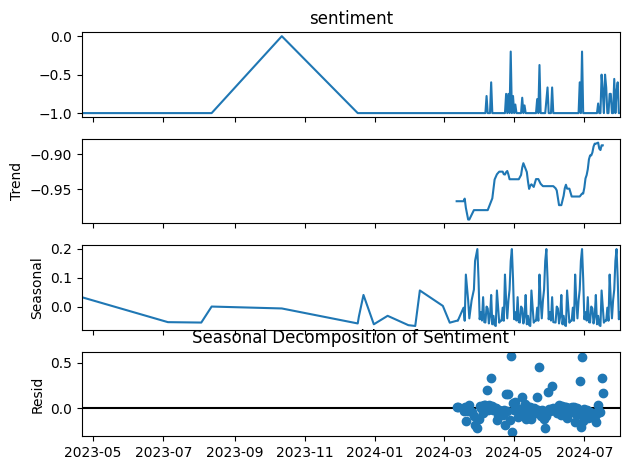

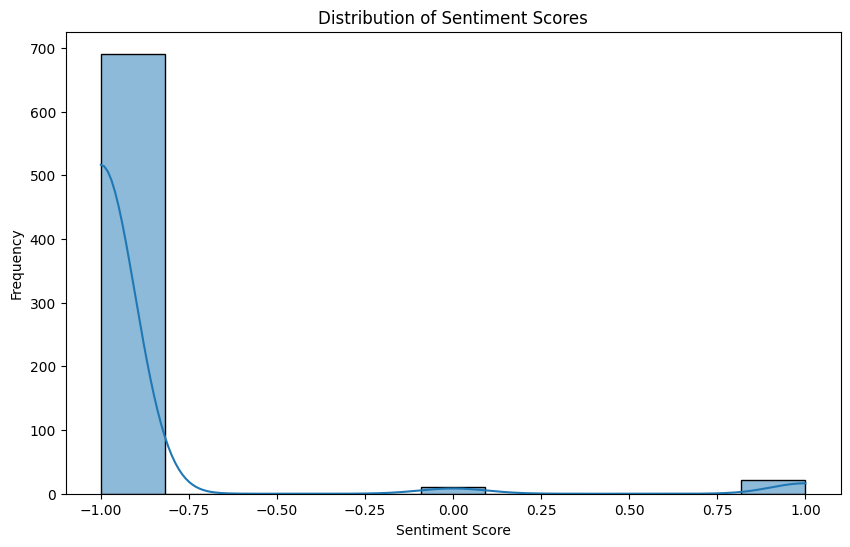

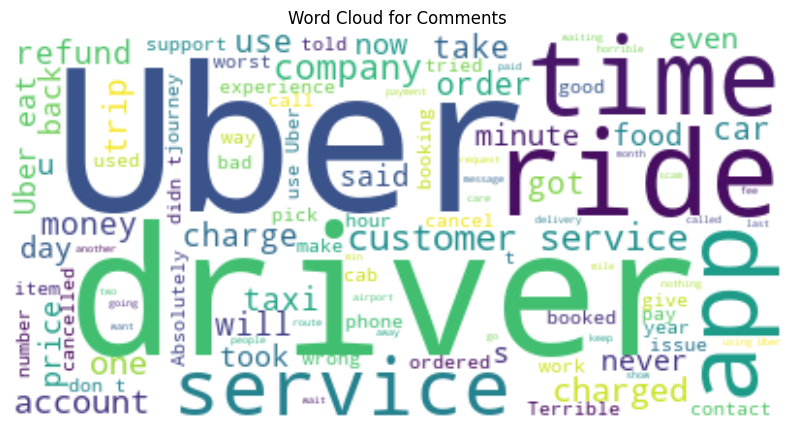

Linear Regression - Mean Squared Error: 0.0749
Decision Tree - Mean Squared Error: 0.1629
Support Vector Machine - Mean Squared Error: 0.0762
Random Forest - Mean Squared Error: 0.1292
XGBoost - Mean Squared Error: 0.1624


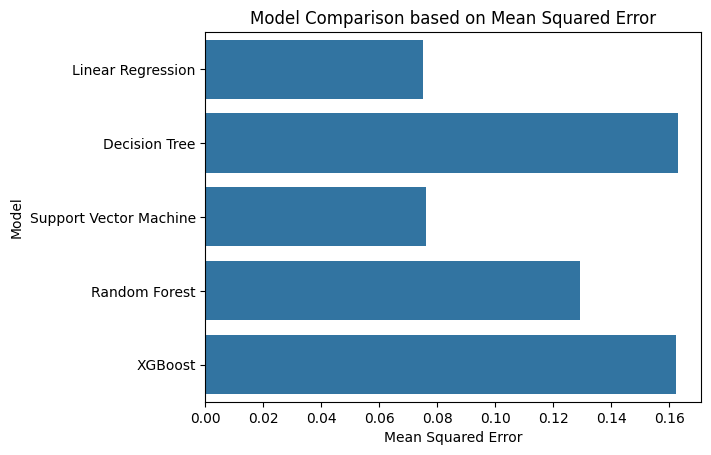

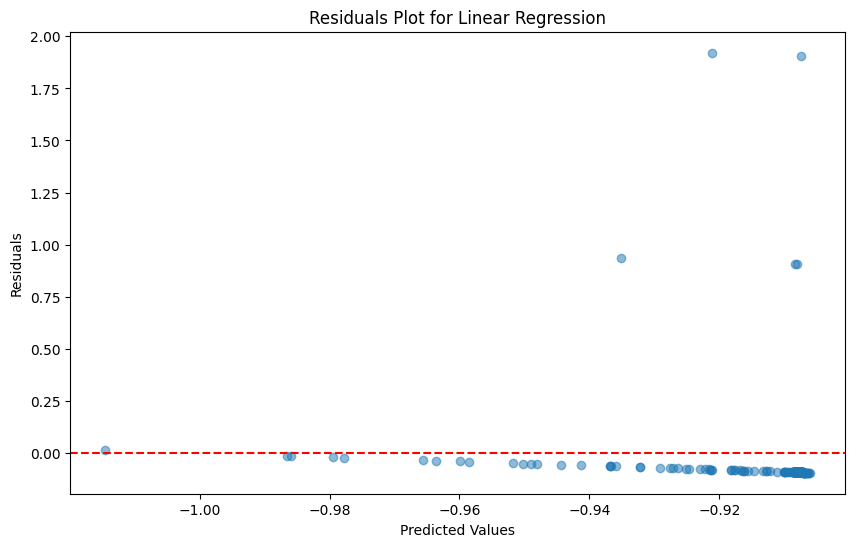

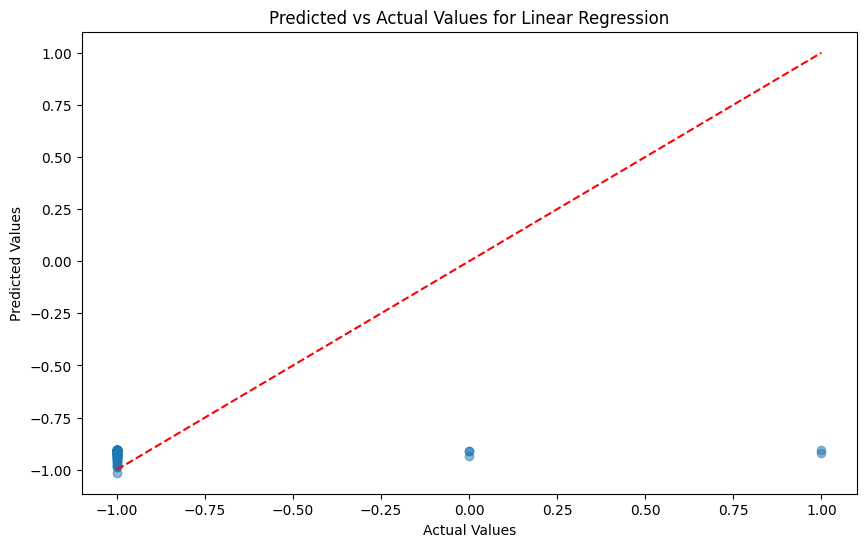

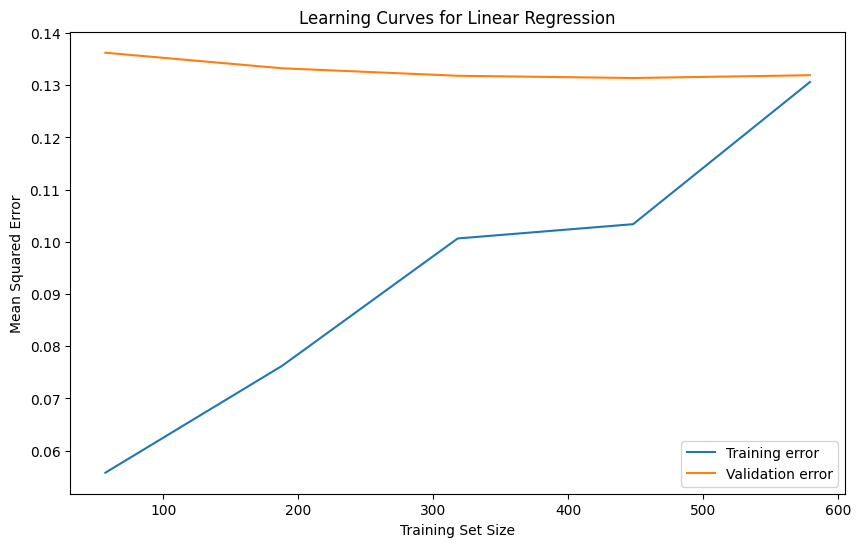

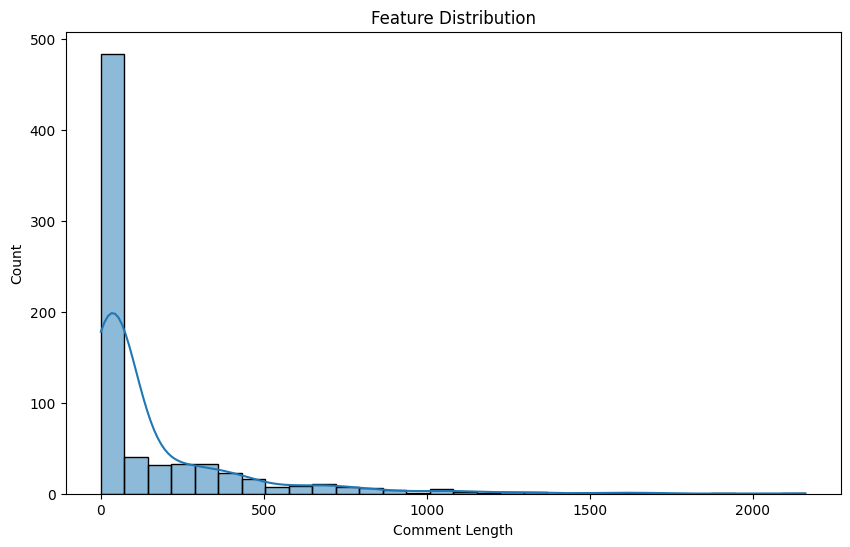

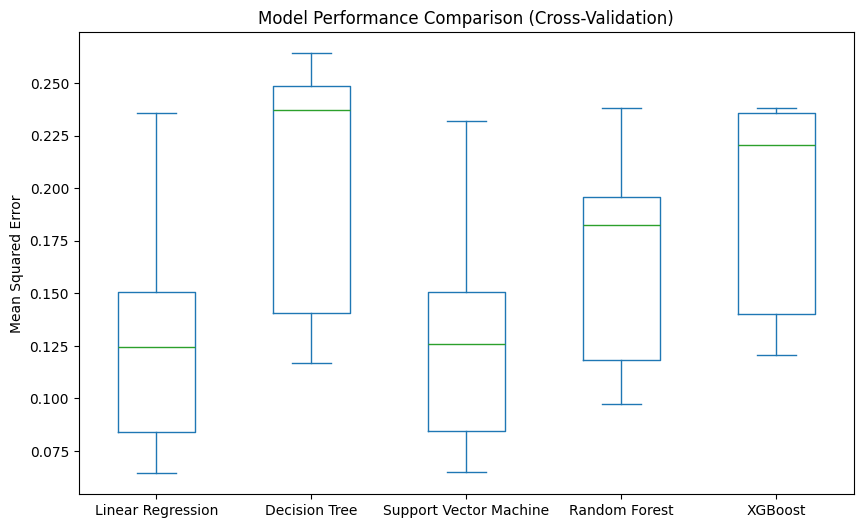

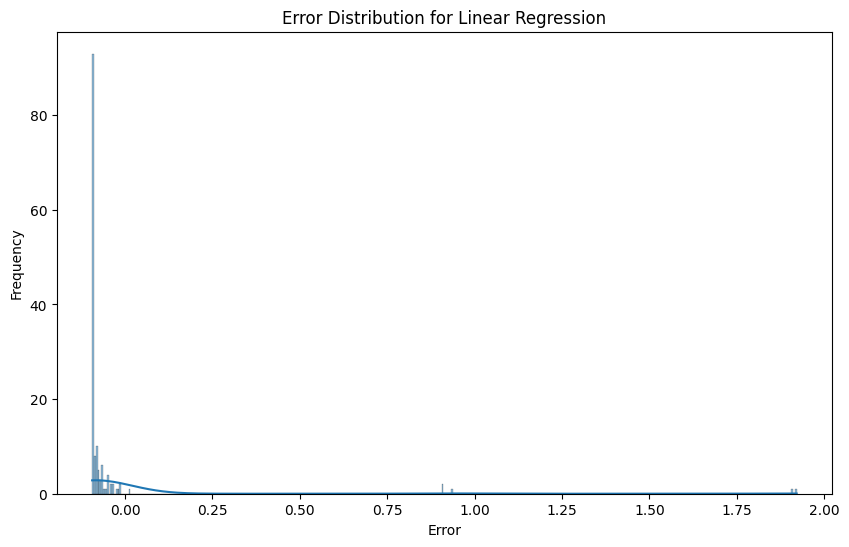

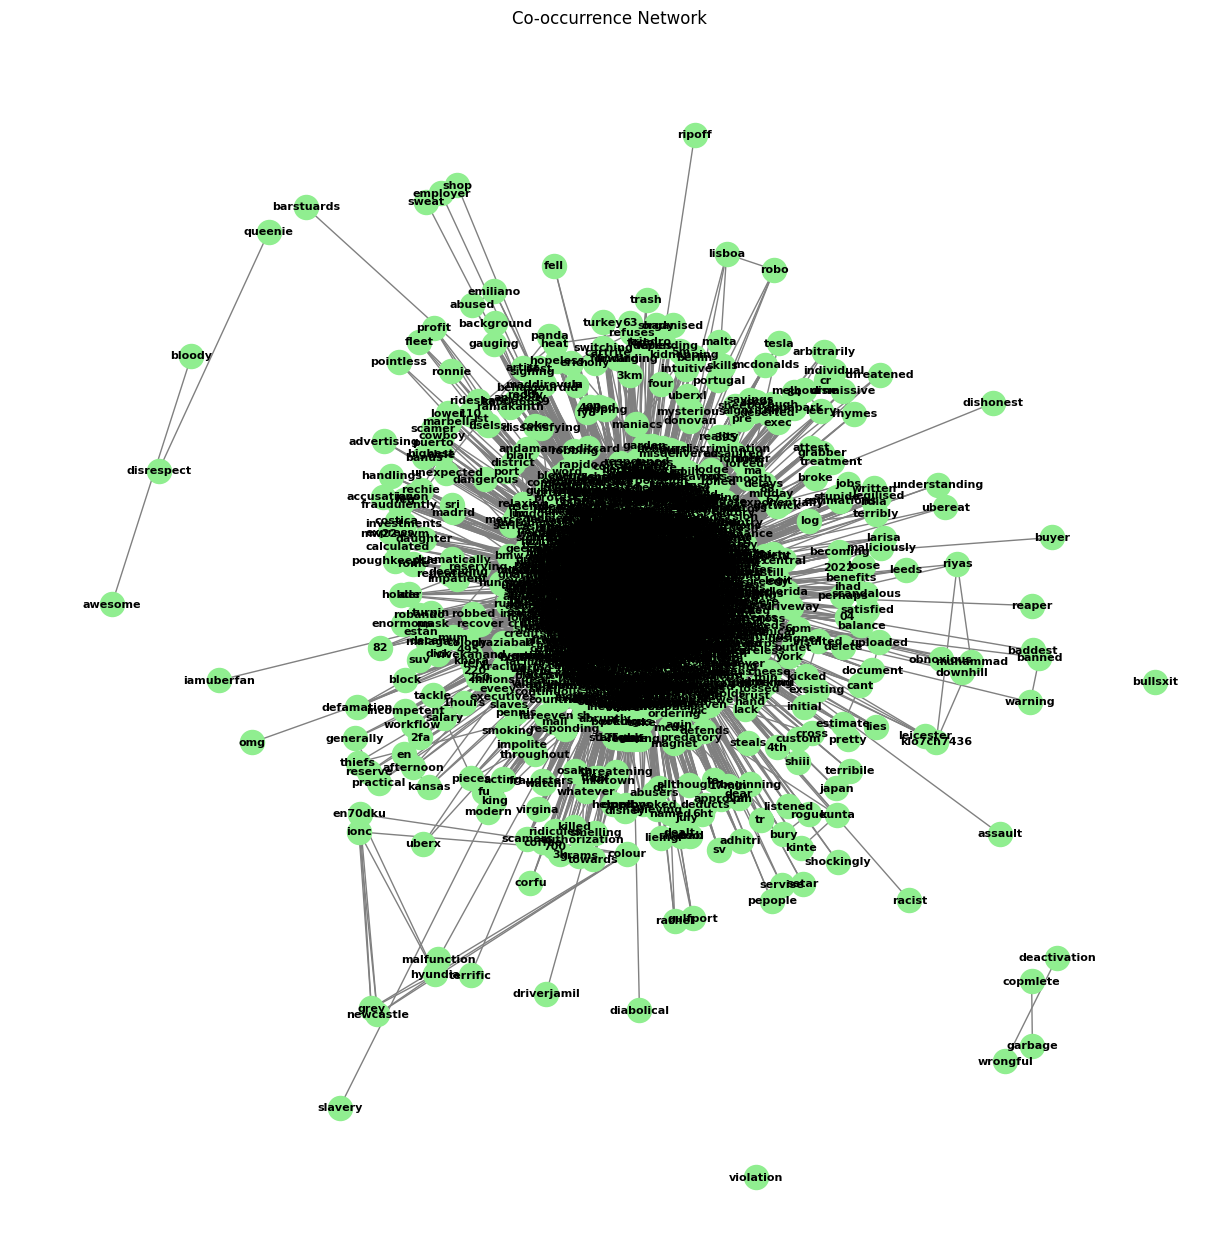

In [2]:
#Part 4(Comprehensive Sentiment Analysis and Predictive Modeling) for Uber dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import networkx as nx
from sklearn.model_selection import learning_curve, cross_val_score

# Load your Excel file
df = pd.read_excel(r"C:\Users\prabi\OneDrive\Desktop\V sem\FDS_project\Datasets\Uber.xlsx")

# Basic Preprocessing

# --- Comment Length Calculation with Error Handling ---
df['comment_length'] = df['Comment'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# --- Sentiment Mapping ---
df['sentiment'] = df['Outcome'].str.lower().map({'positive': 1, 'neutral': 0, 'negative': -1})

# Check if sentiment is valid
if df['sentiment'].isna().sum() == 0:

    # --- Time Series Analysis (If Date exists) ---
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])  # Drop rows where 'Date' conversion failed
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)  # Ensure data is sorted by date
        # Resample if necessary (e.g., daily)
        df_resampled = df['sentiment'].resample('D').mean()
        result = seasonal_decompose(df_resampled.dropna(), model='additive', period=30)
        result.plot()
        plt.title('Seasonal Decomposition of Sentiment')
        plt.show()

    # --- Sentiment Distribution Analysis ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sentiment'], kde=True)
    plt.title("Distribution of Sentiment Scores")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()

    # --- Word Cloud for Comment Analysis ---
    text = " ".join(comment for comment in df['Comment'] if isinstance(comment, str))
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Comments")
    plt.show()

    # --- Predictive Analytics ---
    X = df[['comment_length']]  # You can add other features here
    y = df['sentiment']

    # Ensure there are no NaN values in X and y
    valid_indices = X['comment_length'].notna() & y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    # Split the data into training and test sets
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'Support Vector Machine': SVR(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        # Train, predict, and evaluate each model
        results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name] = mse
            print(f'{name} - Mean Squared Error: {mse:.4f}')

        # --- Compare the results ---
        results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
        sns.barplot(x='Mean Squared Error', y='Model', data=results_df)
        plt.title("Model Comparison based on Mean Squared Error")
        plt.show()

        # --- Residual Plot for Best Performing Model ---
        best_model_name = min(results, key=results.get)
        best_model = models[best_model_name]
        y_pred = best_model.predict(X_test)
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {best_model_name}')
        plt.show()

        # --- Predicted vs Actual Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs Actual Values for {best_model_name}')
        plt.show()

        # --- Learning Curves ---
        train_sizes, train_scores, test_scores = learning_curve(
            best_model, X, y, cv=5, scoring='neg_mean_squared_error')
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training error')
        plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation error')
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Squared Error')
        plt.title(f'Learning Curves for {best_model_name}')
        plt.legend()
        plt.show()

        # --- Feature Distribution Plot ---
        plt.figure(figsize=(10, 6))
        sns.histplot(df['comment_length'], bins=30, kde=True)
        plt.xlabel('Comment Length')
        plt.title('Feature Distribution')
        plt.show()

        # --- Model Performance Comparison Box Plot ---
        cv_results = {}
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            cv_results[name] = -scores
        cv_results_df = pd.DataFrame(cv_results)
        cv_results_df.plot.box(figsize=(10, 6))
        plt.title('Model Performance Comparison (Cross-Validation)')
        plt.ylabel('Mean Squared Error')
        plt.show()

        # --- Error Distribution Plot ---
        errors = y_test - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title(f'Error Distribution for {best_model_name}')
        plt.show()

        # --- Co-occurrence Network ---
        comments = [comment for comment in df['Comment'] if isinstance(comment, str)]
        vectorizer = CountVectorizer()
        X_counts = vectorizer.fit_transform(comments)
        terms = vectorizer.get_feature_names_out()

        co_occurrence = (X_counts.T @ X_counts).toarray()
        np.fill_diagonal(co_occurrence, 0)

        G = nx.Graph()
        for i in range(len(terms)):
            G.add_node(terms[i])

        for i in range(len(terms)):
            for j in range(i+1, len(terms)):
                if co_occurrence[i, j] > 0:
                    G.add_edge(terms[i], terms[j], weight=co_occurrence[i, j])

        pos = nx.spring_layout(G, k=0.15)
        plt.figure(figsize=(12, 12))
        nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightgreen',
                font_size=8, font_weight='bold', edge_color='gray')
        plt.title('Co-occurrence Network')
        plt.show()
    else:
        print("Not enough data for modeling.")
else:
    print("No valid sentiment data available.")


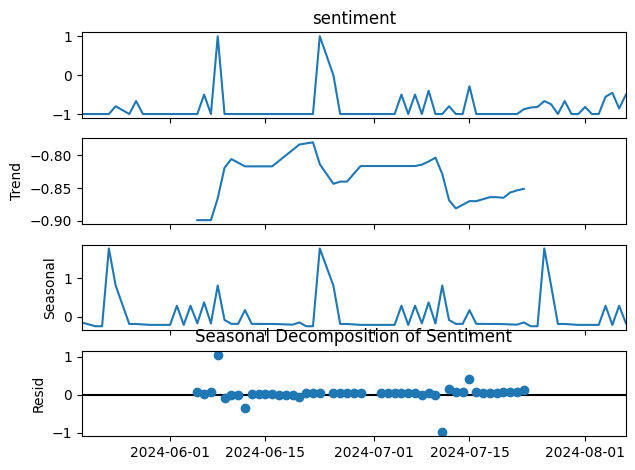

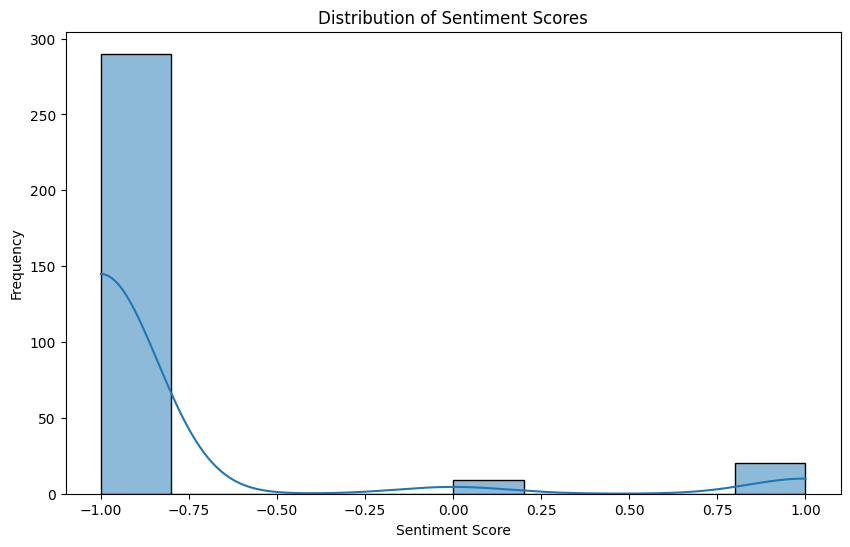

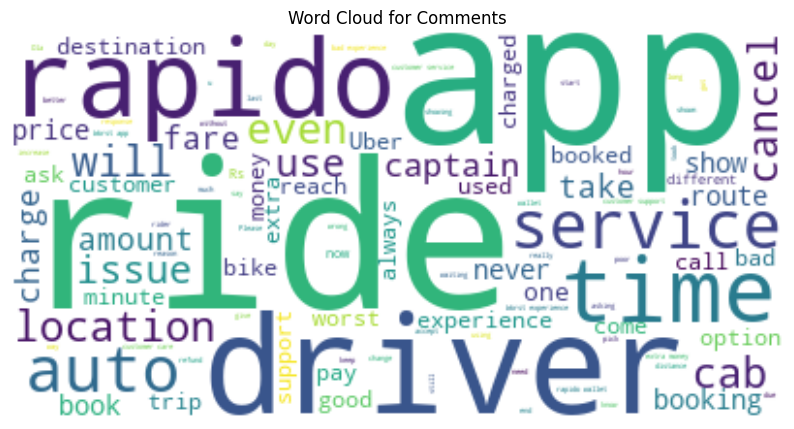

Linear Regression - Mean Squared Error: 0.2240
Decision Tree - Mean Squared Error: 0.3906
Support Vector Machine - Mean Squared Error: 0.2163
Random Forest - Mean Squared Error: 0.2558
XGBoost - Mean Squared Error: 0.4494


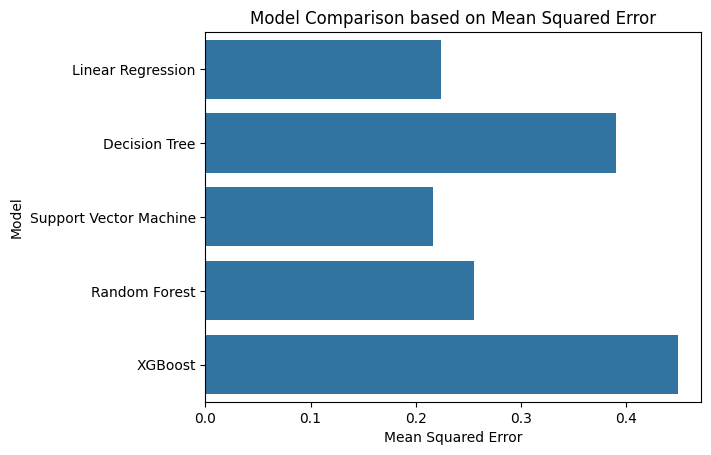

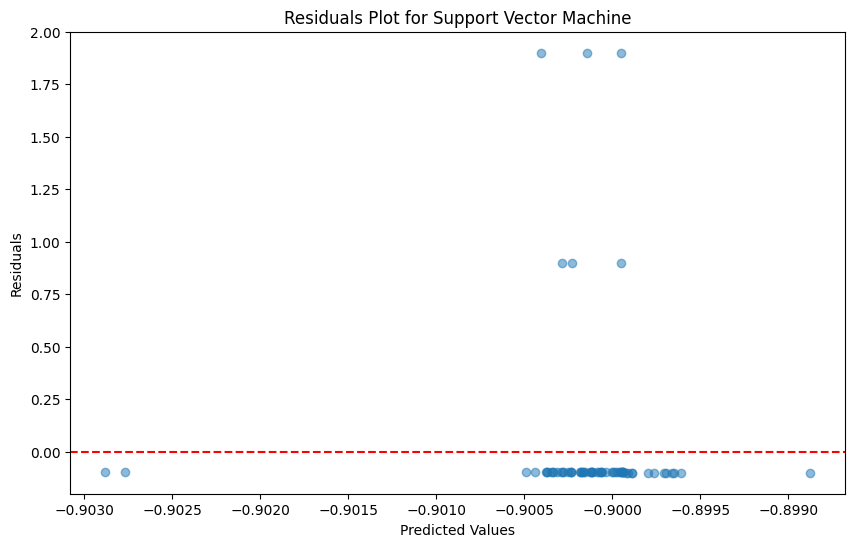

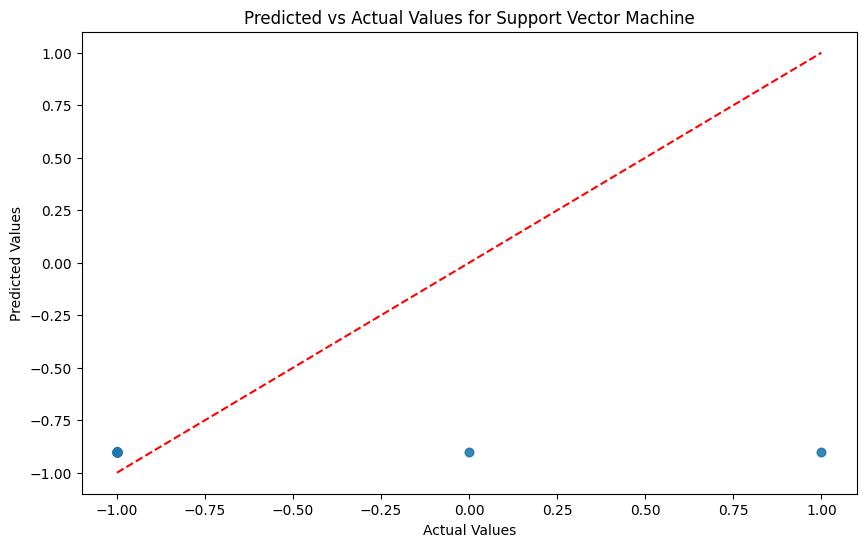

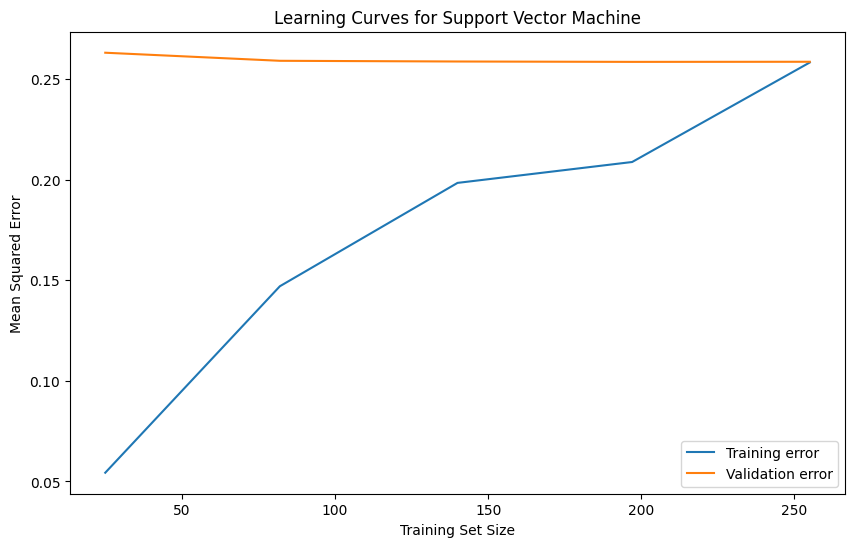

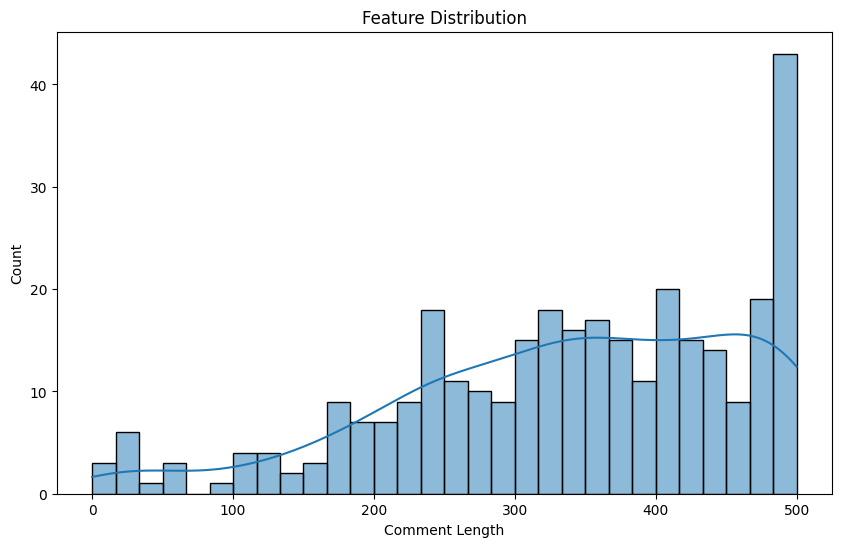

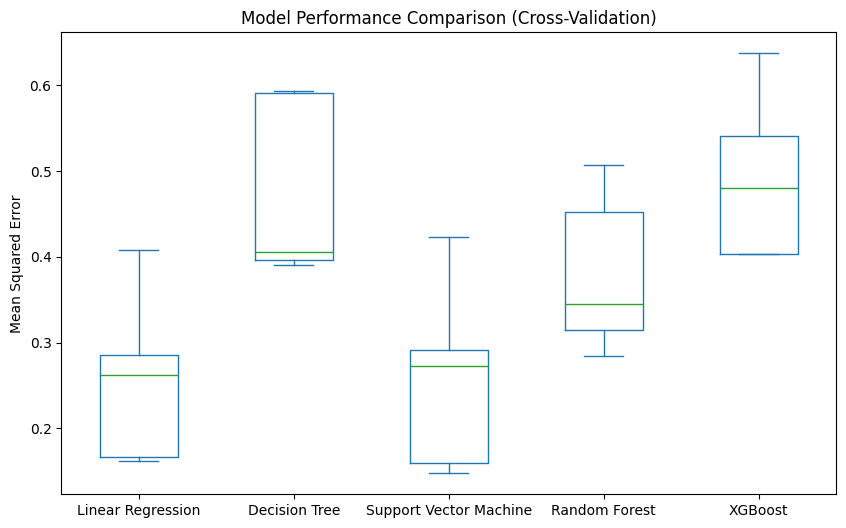

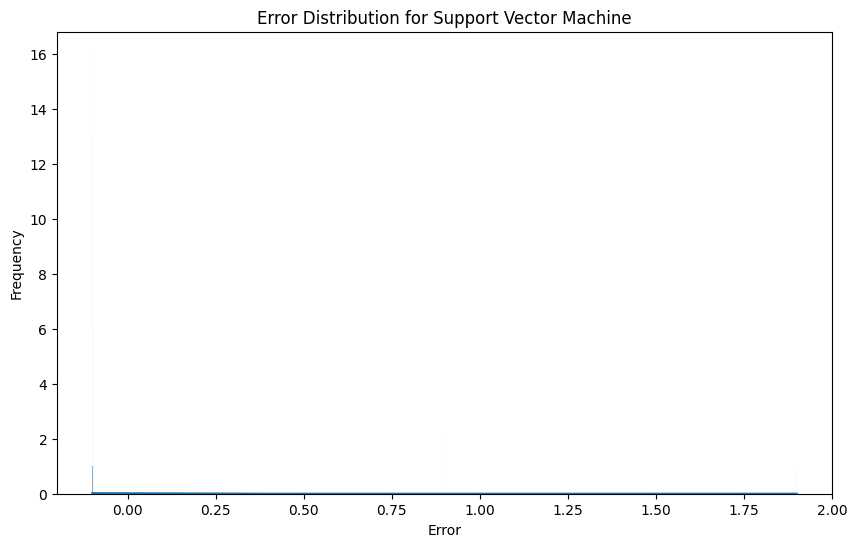

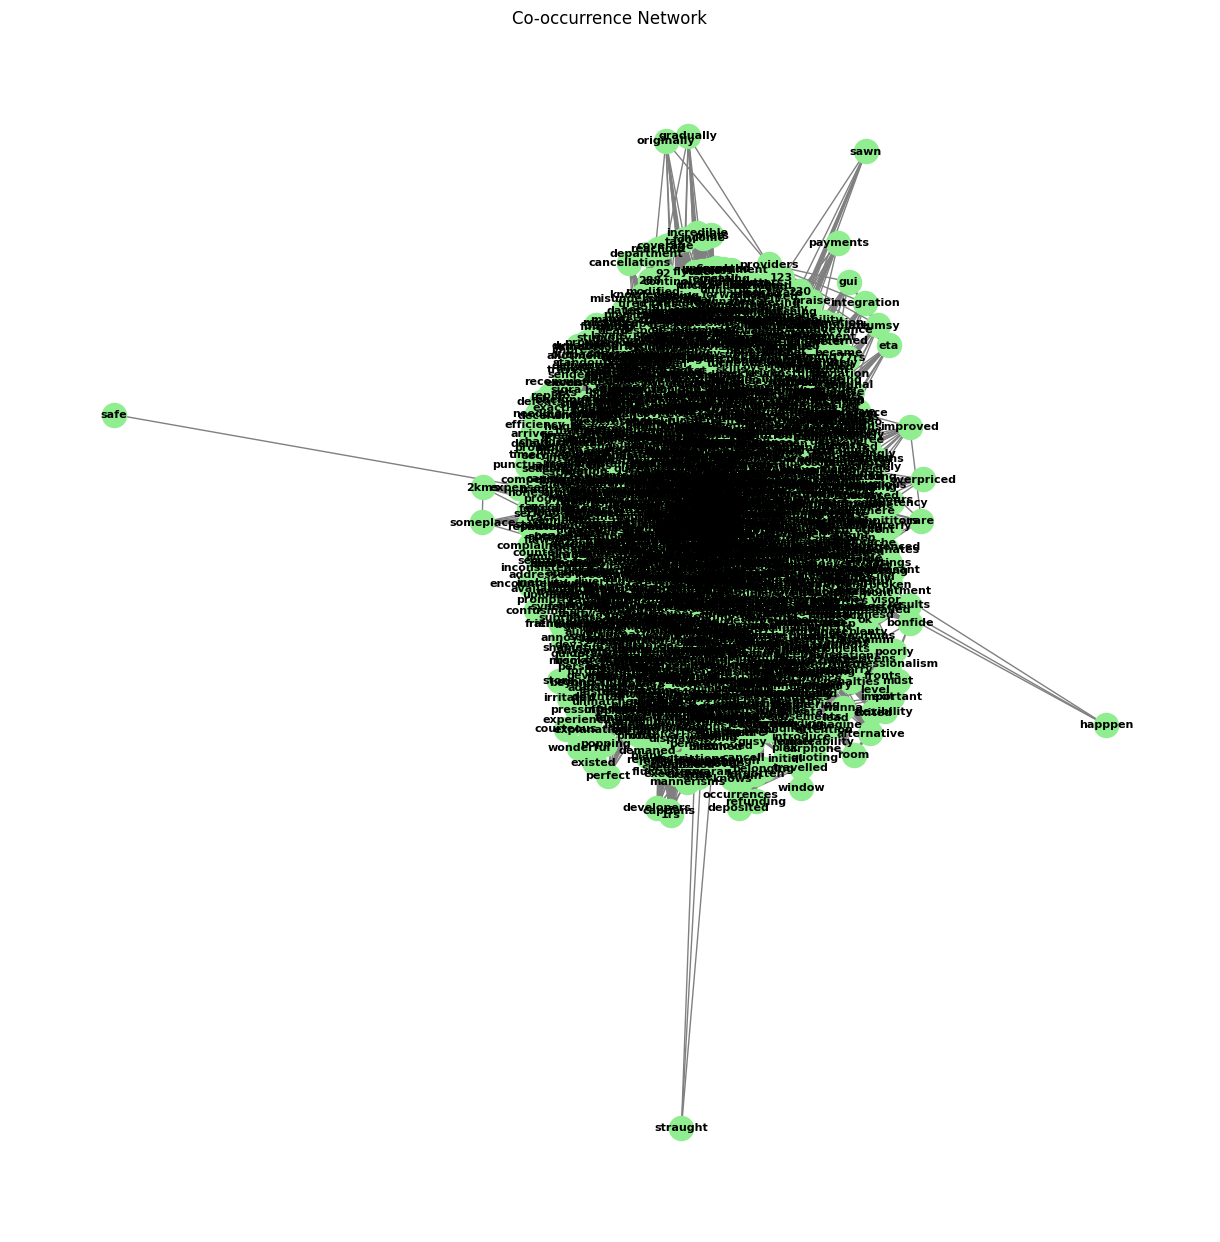

In [3]:
#Part 4(Comprehensive Sentiment Analysis and Predictive Modeling) for Rapido dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import networkx as nx
from sklearn.model_selection import learning_curve, cross_val_score

# Load your Excel file
df = pd.read_excel(r"C:\Users\prabi\OneDrive\Desktop\V sem\FDS_project\Datasets\Rapido1.xlsx")

# Basic Preprocessing

# --- Comment Length Calculation with Error Handling ---
df['comment_length'] = df['Comment'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# --- Sentiment Mapping ---
df['sentiment'] = df['Outcome'].str.lower().map({'positive': 1, 'neutral': 0, 'negative': -1})

# Check if sentiment is valid
if df['sentiment'].isna().sum() == 0:

    # --- Time Series Analysis (If Date exists) ---
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])  # Drop rows where 'Date' conversion failed
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)  # Ensure data is sorted by date
        # Resample if necessary (e.g., daily)
        df_resampled = df['sentiment'].resample('D').mean()
        result = seasonal_decompose(df_resampled.dropna(), model='additive', period=30)
        result.plot()
        plt.title('Seasonal Decomposition of Sentiment')
        plt.show()

    # --- Sentiment Distribution Analysis ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sentiment'], kde=True)
    plt.title("Distribution of Sentiment Scores")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()

    # --- Word Cloud for Comment Analysis ---
    text = " ".join(comment for comment in df['Comment'] if isinstance(comment, str))
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Comments")
    plt.show()

    # --- Predictive Analytics ---
    X = df[['comment_length']]  # You can add other features here
    y = df['sentiment']

    # Ensure there are no NaN values in X and y
    valid_indices = X['comment_length'].notna() & y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    # Split the data into training and test sets
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'Support Vector Machine': SVR(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        # Train, predict, and evaluate each model
        results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name] = mse
            print(f'{name} - Mean Squared Error: {mse:.4f}')

        # --- Compare the results ---
        results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
        sns.barplot(x='Mean Squared Error', y='Model', data=results_df)
        plt.title("Model Comparison based on Mean Squared Error")
        plt.show()

        # --- Residual Plot for Best Performing Model ---
        best_model_name = min(results, key=results.get)
        best_model = models[best_model_name]
        y_pred = best_model.predict(X_test)
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {best_model_name}')
        plt.show()

        # --- Predicted vs Actual Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs Actual Values for {best_model_name}')
        plt.show()

        # --- Learning Curves ---
        train_sizes, train_scores, test_scores = learning_curve(
            best_model, X, y, cv=5, scoring='neg_mean_squared_error')
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training error')
        plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation error')
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Squared Error')
        plt.title(f'Learning Curves for {best_model_name}')
        plt.legend()
        plt.show()

        # --- Feature Distribution Plot ---
        plt.figure(figsize=(10, 6))
        sns.histplot(df['comment_length'], bins=30, kde=True)
        plt.xlabel('Comment Length')
        plt.title('Feature Distribution')
        plt.show()

        # --- Model Performance Comparison Box Plot ---
        cv_results = {}
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            cv_results[name] = -scores
        cv_results_df = pd.DataFrame(cv_results)
        cv_results_df.plot.box(figsize=(10, 6))
        plt.title('Model Performance Comparison (Cross-Validation)')
        plt.ylabel('Mean Squared Error')
        plt.show()

        # --- Error Distribution Plot ---
        errors = y_test - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title(f'Error Distribution for {best_model_name}')
        plt.show()

        # --- Co-occurrence Network ---
        comments = [comment for comment in df['Comment'] if isinstance(comment, str)]
        vectorizer = CountVectorizer()
        X_counts = vectorizer.fit_transform(comments)
        terms = vectorizer.get_feature_names_out()

        co_occurrence = (X_counts.T @ X_counts).toarray()
        np.fill_diagonal(co_occurrence, 0)

        G = nx.Graph()
        for i in range(len(terms)):
            G.add_node(terms[i])

        for i in range(len(terms)):
            for j in range(i+1, len(terms)):
                if co_occurrence[i, j] > 0:
                    G.add_edge(terms[i], terms[j], weight=co_occurrence[i, j])

        pos = nx.spring_layout(G, k=0.15)
        plt.figure(figsize=(12, 12))
        nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightgreen',
                font_size=8, font_weight='bold', edge_color='gray')
        plt.title('Co-occurrence Network')
        plt.show()
    else:
        print("Not enough data for modeling.")
else:
    print("No valid sentiment data available.")


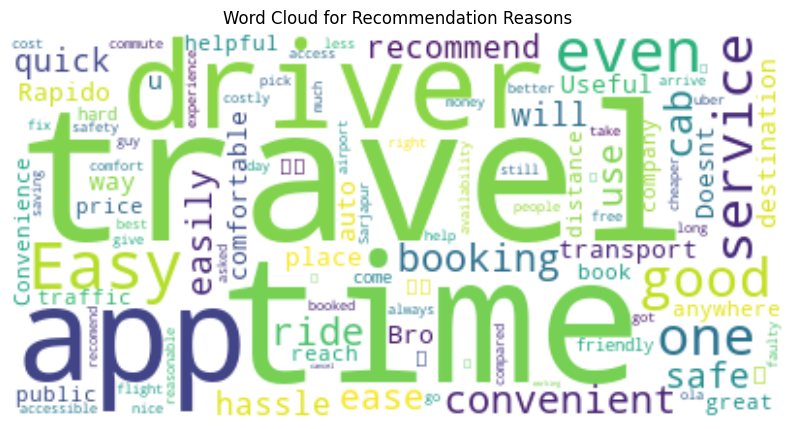

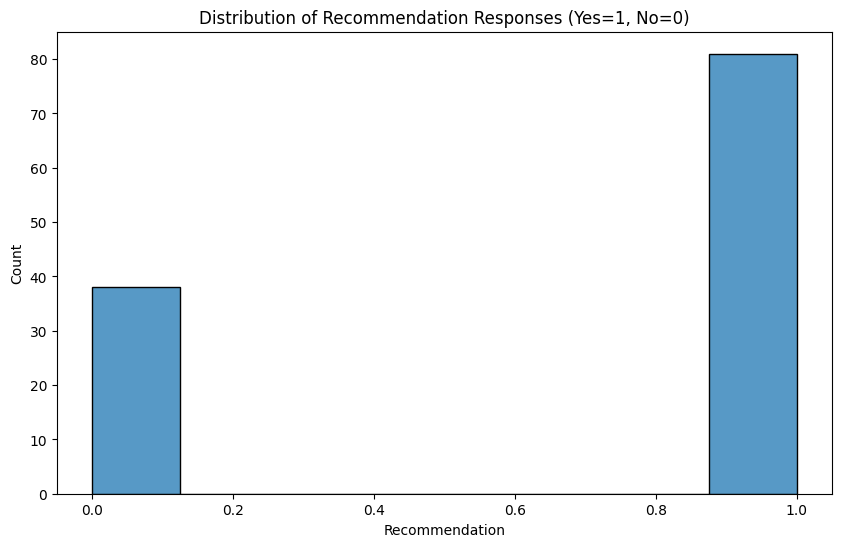

Linear Regression - Mean Squared Error: 0.0528
Decision Tree - Mean Squared Error: 0.1667
Support Vector Machine - Mean Squared Error: 0.3313
Random Forest - Mean Squared Error: 0.1090
XGBoost - Mean Squared Error: 0.1258


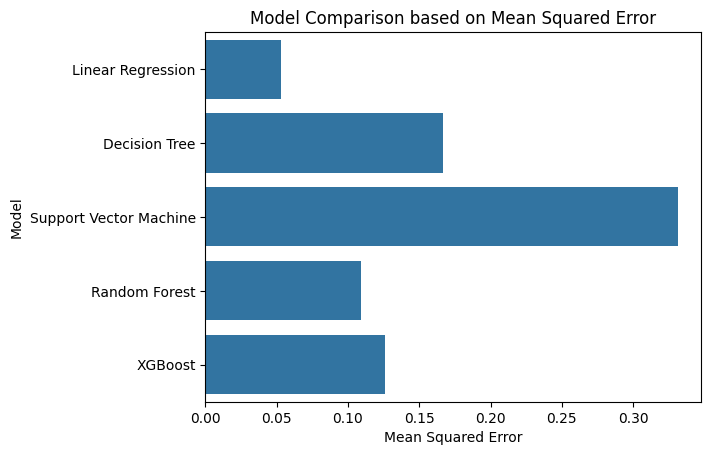

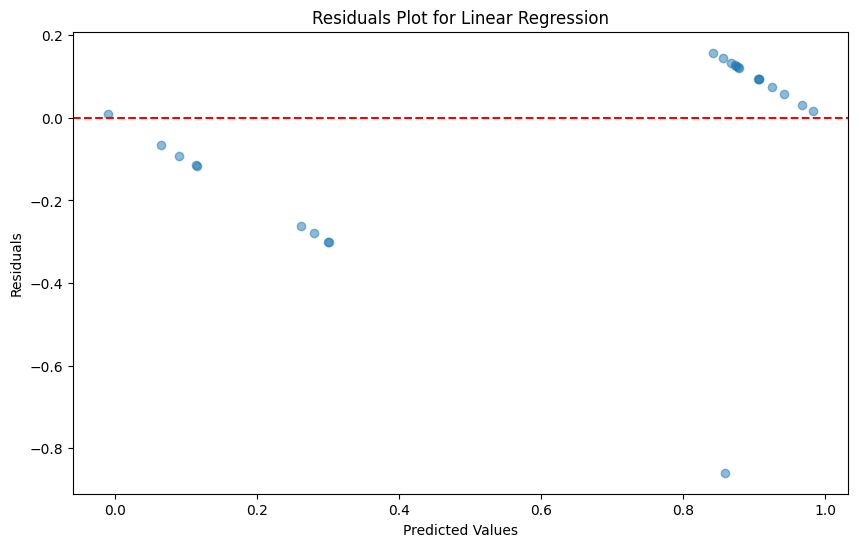

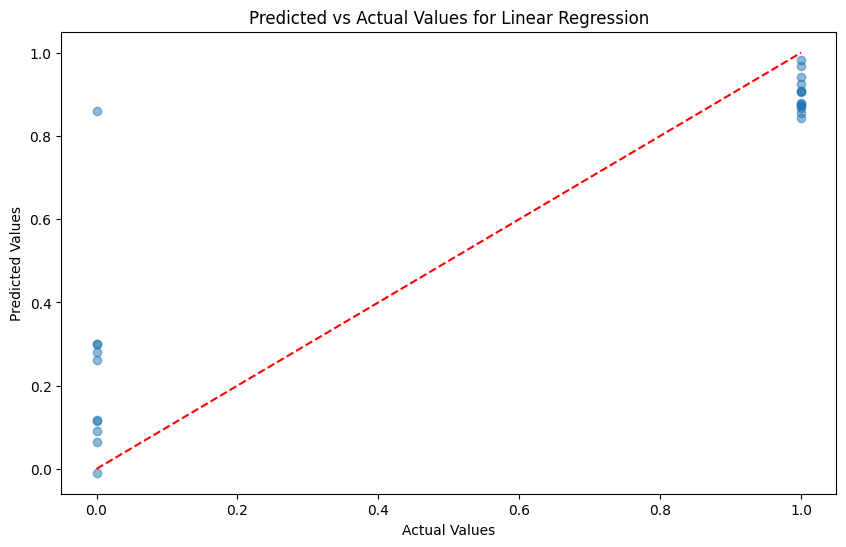

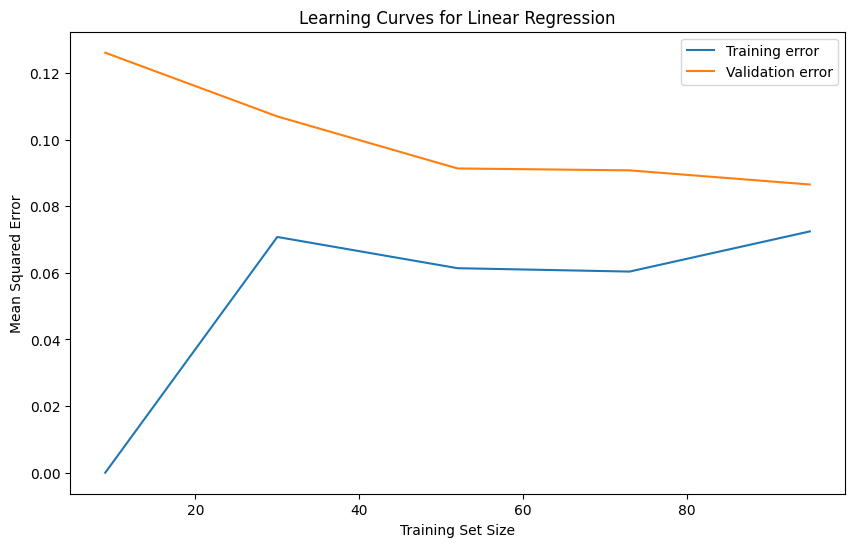

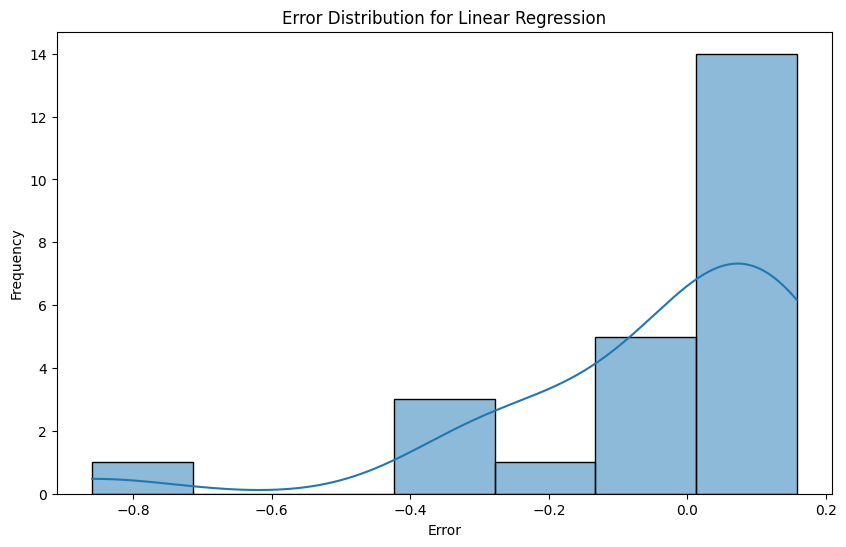

C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: G

In [4]:
#Part 4(Comprehensive Sentiment Analysis and Predictive Modeling) for Special dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import learning_curve, cross_val_score
import networkx as nx
from sklearn.metrics import mean_squared_error

# Load the "Special" dataset
df = pd.read_excel(r"C:\Users\prabi\OneDrive\Desktop\V sem\FDS_project\Datasets\Special.xlsx")

# Basic Preprocessing

# --- Descriptive Text Length Calculation with Error Handling ---
df['text_length'] = df['Please explain why you would recommend it?'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# --- Mapping Yes/No Responses to Numerical Values ---
df['commute'] = df['Do you commute via travel apps like Ola, Uber and Rapido?'].map({'Yes': 1, 'No': 0})
df['liked_experience'] = df['If you ever did commute, did you like the experience?'].map({'Yes': 1, 'No': 0})
df['recommend'] = df['Would you recommend any of the above listed apps to others?'].map({'Yes': 1, 'No': 0})

# --- Check for missing data ---
if df[['commute', 'liked_experience', 'recommend']].isna().sum().sum() == 0:

    # --- Text Analysis: Word Cloud ---
    text = " ".join(comment for comment in df['Please explain why you would recommend it?'] if isinstance(comment, str))
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Recommendation Reasons")
    plt.show()

    # --- Sentiment Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['recommend'], kde=False)
    plt.title("Distribution of Recommendation Responses (Yes=1, No=0)")
    plt.xlabel("Recommendation")
    plt.ylabel("Count")
    plt.show()

    # --- Predictive Analytics ---
    X = df[['text_length', 'commute', 'liked_experience']]  # Features: Text length, commute, experience
    y = df['recommend']  # Target: Recommend (Yes/No)

    # Ensure no missing values in X and y
    valid_indices = X.notna().all(axis=1) & y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    if len(X) > 0:
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'Support Vector Machine': SVR(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        # Train, predict, and evaluate each model
        results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name] = mse
            print(f'{name} - Mean Squared Error: {mse:.4f}')

        # --- Compare the results ---
        results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
        sns.barplot(x='Mean Squared Error', y='Model', data=results_df)
        plt.title("Model Comparison based on Mean Squared Error")
        plt.show()

        # --- Best Performing Model Residuals Plot ---
        best_model_name = min(results, key=results.get)
        best_model = models[best_model_name]
        y_pred = best_model.predict(X_test)
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {best_model_name}')
        plt.show()

        # --- Predicted vs Actual Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs Actual Values for {best_model_name}')
        plt.show()

        # --- Learning Curves ---
        train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training error')
        plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation error')
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Squared Error')
        plt.title(f'Learning Curves for {best_model_name}')
        plt.legend()
        plt.show()

        # --- Error Distribution Plot ---
        errors = y_test - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title(f'Error Distribution for {best_model_name}')
        plt.show()

        # --- Co-occurrence Network for Text Data ---
        comments = [comment for comment in df['Please explain why you would recommend it?'] if isinstance(comment, str)]
        vectorizer = CountVectorizer()
        X_counts = vectorizer.fit_transform(comments)
        terms = vectorizer.get_feature_names_out()

        co_occurrence = (X_counts.T @ X_counts).toarray()
        np.fill_diagonal(co_occurrence, 0)

        G = nx.Graph()
        for i in range(len(terms)):
            G.add_node(terms[i])

        for i in range(len(terms)):
            for j in range(i + 1, len(terms)):
                if co_occurrence[i, j] > 0:
                    G.add_edge(terms[i], terms[j], weight=co_occurrence[i, j])

        pos = nx.spring_layout(G, k=0.15)
        plt.figure(figsize=(12, 12))
        nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_weight='bold', edge_color='gray')
        plt.title('Co-occurrence Network for Recommendation Explanations')
        plt.show()

    else:
        print("Not enough data for modeling.")
else:
    print("No valid data available.")
